In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from tqdm.notebook import tqdm

In [2]:
class Mnist(Dataset):
    def __init__(self, img_gzip, label_gzip, base_dir):
        self.img_gzip_path = base_dir + img_gzip
        self.label_gzip_path = base_dir + label_gzip
        self.imgs, self.labels = None, None
        self.load()
        
    def load(self):
        with open(self.img_gzip_path,'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            nrows, ncols = struct.unpack(">II", f.read(8))
            self.imgs = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))\
                     .reshape((size, nrows, ncols, 1))
            self.imgs = np.transpose(self.imgs, (0,3,1,2))

        with open(self.label_gzip_path,'rb') as f:
            magic, size = struct.unpack('>II', f.read(8))
            self.labels = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.imgs[idx], dtype=torch.float32)/255.0
        label = torch.tensor(self.labels[idx])
        return img, label

In [3]:
base_dir = 'data/mnist/'

img_gzip = "train-images.idx3-ubyte"
label_gzip = "train-labels.idx1-ubyte"

test_img_gzip = "t10k-images.idx3-ubyte"
test_label_gzip = "t10k-labels.idx1-ubyte"

In [4]:
dataset = Mnist(img_gzip = img_gzip,
                label_gzip = label_gzip,
                base_dir = base_dir)

test_dataset = Mnist(img_gzip = test_img_gzip,
                label_gzip = test_label_gzip,
                base_dir = base_dir)

In [5]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

In [6]:
def plot_img(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)

In [7]:
img, label = next(iter(dataloader))

In [8]:
patch_size = 4
num_patches = img.shape[-1]//patch_size
print("Number of patches along 1 dim: ", num_patches)

Number of patches along 1 dim:  7


In [9]:
embedding_dim = 16

In [10]:
break_patches = nn.Conv2d(in_channels = 1, 
                          out_channels = embedding_dim, 
                          kernel_size = patch_size, 
                          stride = patch_size)

In [11]:
break_patches(img).flatten(start_dim = -2).shape

torch.Size([32, 16, 49])

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, input_channel, patch_size, embedding_dim, 
                       num_patch, batch_size):
        super().__init__()
        self.patch_layer = nn.Conv2d(input_channel, embedding_dim, 
                                     kernel_size = patch_size, 
                                     stride = patch_size)
        
        self.class_token = nn.Parameter(torch.randn(batch_size, embedding_dim, 1))
        self.positional_embedding = nn.Parameter(torch.randn(embedding_dim, num_patch + 1))

    def forward(self, x):
        x = self.patch_layer(x) # batch_size x embedding_dim x height x width
        x = x.flatten(start_dim = -2) # batch_size x embedding_dim x (height x width)
        x = torch.cat([self.class_token, x], dim = -1) # batch_size x embedding_dim x (height x width + 1)
        x  = x + self.positional_embedding
        x = torch.transpose(x, -2, -1) #batch_size x (height x width + 1)x embedding_dim
        return x

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, projection_dim, num_heads = 1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        self.self_attention = nn.MultiheadAttention(embedding_dim, num_heads, batch_first = True)

        self.mlp_block = nn.Sequential(*[
            nn.Linear(embedding_dim, projection_dim), 
            nn.GELU(), 
            nn.Linear(projection_dim, embedding_dim),
        ])

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.self_attention(x,x,x)[0] + x
        x = self.mlp_block(x) + x
        
        return x

In [14]:
class Model(nn.Module):
    def __init__(self, patch_size, 
                 output_dim, NUM_PATCH, BATCH_SIZE,
                 L = 2, input_channel = 1, 
                 embedding_dim = 16, projection_dim = 16, num_heads = 2):
        super().__init__()

        self.patch_embedding = PatchEmbedding(input_channel, 
                                              patch_size, embedding_dim, 
                                              NUM_PATCH, BATCH_SIZE)

        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim, projection_dim = embedding_dim) for _ in range(L)])
        self.output_layer = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)            
        x = x[:, 0, :]
        x = self.output_layer(x)
        return x

In [15]:
device = torch.device('mps')

In [16]:
NUM_PATCH = (img.size(-1) // patch_size) ** 2
BATCH_SIZE = batch_size

In [17]:
model = Model(patch_size = patch_size, output_dim = 10, L=4,
              NUM_PATCH = NUM_PATCH, BATCH_SIZE = BATCH_SIZE).to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def evaluate(model, dataloader):
    model.eval()
    loss_ = []
    acc = 0
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        output = torch.argmax(output, dim =  -1)
        output = (output == y_batch).sum()
        acc += output.item() / x_batch.size(0)
        loss_.append(loss.item())
    
    acc = acc / len(dataloader)
    loss_ = np.mean(loss_)
    return loss_, acc

In [20]:
epochs = 20
history = {'loss':[]}
for epoch in tqdm(range(epochs)):
    acc, loss_ = 0, []
    model.train()
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        
        acc += (torch.argmax(output, dim = -1) == y_batch).sum() / x_batch.size(0)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())

    acc = acc / len(dataloader)
    loss_ = np.mean(loss_)
    history['loss'].append(loss_)
    
    test_loss, test_acc = evaluate(model, test_dataloader)
    print(f"[{epoch+1}] Loss : {loss_:.4f} Acc : {acc : .2f} \
    Test Loss : {test_loss: .4f} Test Acc : {test_acc : .2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[1] Loss : 0.9702 Acc :  0.67     Test Loss :  0.4184 Test Acc :  0.87
[2] Loss : 0.3571 Acc :  0.89     Test Loss :  0.2855 Test Acc :  0.91
[3] Loss : 0.2775 Acc :  0.91     Test Loss :  0.3096 Test Acc :  0.90
[4] Loss : 0.2414 Acc :  0.93     Test Loss :  0.2103 Test Acc :  0.94
[5] Loss : 0.2186 Acc :  0.93     Test Loss :  0.1967 Test Acc :  0.94
[6] Loss : 0.2031 Acc :  0.94     Test Loss :  0.1839 Test Acc :  0.94
[7] Loss : 0.1909 Acc :  0.94     Test Loss :  0.1667 Test Acc :  0.95
[8] Loss : 0.1822 Acc :  0.94     Test Loss :  0.1860 Test Acc :  0.94
[9] Loss : 0.1687 Acc :  0.95     Test Loss :  0.1642 Test Acc :  0.95
[10] Loss : 0.1626 Acc :  0.95     Test Loss :  0.1401 Test Acc :  0.96
[11] Loss : 0.1542 Acc :  0.95     Test Loss :  0.1466 Test Acc :  0.95
[12] Loss : 0.1484 Acc :  0.95     Test Loss :  0.1321 Test Acc :  0.96
[13] Loss : 0.1446 Acc :  0.95     Test Loss :  0.1438 Test Acc :  0.95
[14] Loss : 0.1370 Acc :  0.96     Test Loss :  0.1387 Test Acc :  0.96
[

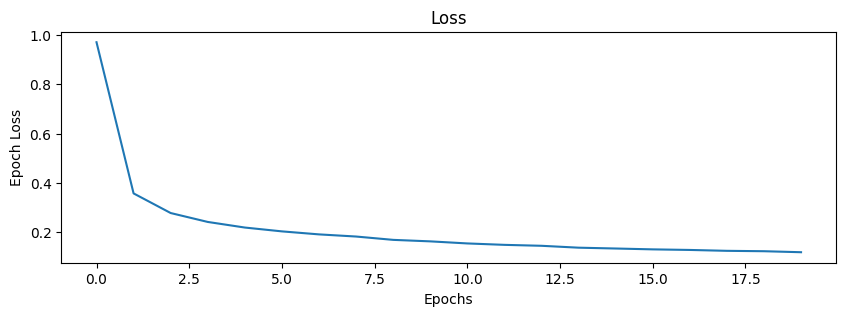

In [29]:
plt.figure(figsize=(10,3))
plt.plot(history['loss'])
_ = plt.gca().set(title='Loss', xlabel='Epochs', ylabel='Epoch Loss')